# Leitura

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, mean_squared_error as mse
pd.set_option('display.max_columns', None)

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [16]:
df = pd.read_parquet("../data/output/RENTAL_USED_BR_Rio_de_Janeiro_NULL_Rio_de_Janeiro_Zona_Norte_Tijuca.parquet")
print(df.shape)
df.head(5)

(1177, 36)


,url,title,description,publicationType,media,street,streetNumber,complement,point_lat,point_lon,amenities,usable_area,floors,type_unit,advertiserContact_phones,whatsappNumber,bedrooms,bathrooms,price,condo_fee,total_fee,elevator,service_area,kitchen_cabinets,party_hall,intercom,playground,builtin_wardrobe,air_conditioning,balcony,gated_community,linha,estacao,distance,pred,error
886,https://www.zapimoveis.com.br/imovel/aluguel-a...,Excelente Apartamento Tipo Casa na Tijuca com ...,Excelente Apartamento Tipo Casa na Tijuca com ...,PREMIUM,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua Conde de Bonfim,None,,NaN,NaN,[PETS_ALLOWED],165,-1.0,APARTMENT,"[2121352868, 21992639310]",21992639310,3,2,2150,0,2150,False,False,False,False,False,False,False,False,False,False,,,NaN,3851.205848,-1701.205848
185,https://www.zapimoveis.com.br/imovel/aluguel-a...,CONDE DE BONFIM 753 APT. 101,TIJUCA PERTO RUA URUGUAI APARTAMENTO TÉRREO CO...,STANDARD,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua Conde de Bonfim,753,apt. 101,-22.933867,-43.241969,"[SAFETY_CIRCUIT, GATED_COMMUNITY, INTERNET_ACC...",120,3.0,APARTMENT,"[2122271564, 2122270636]",,2,2,1300,300,1600,False,False,False,False,True,False,False,False,False,True,Linha 1 do Metrô do Rio de Janeiro,Estação Uruguai,376.239943,3077.771945,-1477.771945
115,https://www.zapimoveis.com.br/imovel/aluguel-a...,Rio de Janeiro - Apartamento Padrão - Tijuca,"Apartamento para Aluguel - Tijuca, 2 Quartos, ...",PREMIUM,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua General Roca,161,,-22.928118,-43.228970,"[ELEVATOR, PLAYGROUND, PARTY_HALL, KITCHEN_CAB...",80,-1.0,APARTMENT,[11111111111],11111111111,2,2,1600,751,2351,True,False,True,True,False,True,False,True,False,False,Linha 1 do Metrô do Rio de Janeiro,Estação Saens Peña,558.928770,3797.025281,-1446.025281
1111,https://www.zapimoveis.com.br/imovel/aluguel-a...,"VAGA DE GARAGEM R$ 0,00 + CONDOMINIO R$250,00",VAGA DE GARAGEM. Alugo vaga de garagem em ótim...,PREMIUM,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua Uruguai,None,,NaN,NaN,"[ELECTRONIC_GATE, CONCIERGE_24H]",15,-1.0,APARTMENT,[21999849896],21999849896,1,1,250,0,250,False,False,False,False,False,False,False,False,False,False,,,NaN,1618.698542,-1368.698542
925,https://www.zapimoveis.com.br/imovel/aluguel-a...,Rio de Janeiro - Apartamento Padrão - Tijuca,"Apartamento para Aluguel - Tijuca, 3 Quartos, ...",PREMIUM,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua Valparaíso,80,,-22.926124,-43.222409,"[BARBECUE_GRILL, POOL, ELEVATOR, PLAYGROUND, S...",120,-1.0,APARTMENT,[11111111111],11111111111,3,2,1500,995,2495,True,True,True,True,False,True,True,False,False,False,Linha 1 do Metrô do Rio de Janeiro,Estação São Francisco Xavier (Metrô Rio),635.031586,3775.489492,-1280.489492


# Exploração

In [17]:
df.isna().sum()

url                           0
title                         0
description                   0
publicationType               0
media                         0
street                       79
streetNumber                418
complement                    0
point_lat                   418
point_lon                   418
amenities                     0
usable_area                   0
floors                        0
type_unit                     0
advertiserContact_phones      0
whatsappNumber                0
bedrooms                      0
bathrooms                     0
price                         0
condo_fee                     0
total_fee                     0
elevator                      0
service_area                  0
kitchen_cabinets              0
party_hall                    0
intercom                      0
playground                    0
builtin_wardrobe              0
air_conditioning              0
balcony                       0
gated_community               0
linha   

In [18]:
qt = df["total_fee"].quantile([0, .01, .25, .5, .75, .99, 1])
qt

0.00        250.00
0.01       1285.68
0.25       2050.00
0.50       2500.00
0.75       3150.00
0.99       6614.40
1.00    1162000.00
Name: total_fee, dtype: float64

<AxesSubplot:>

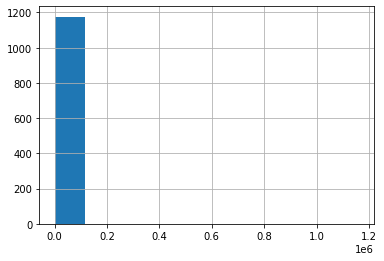

In [19]:
df.total_fee.hist()

<AxesSubplot:>

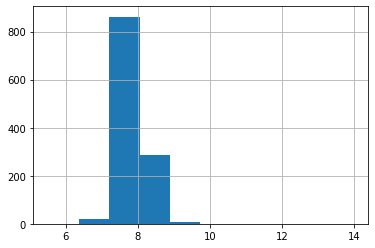

In [20]:
np.log(df.total_fee).hist()

# Treino e teste

In [21]:
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

In [29]:
y = df.total_fee.values
drop_cols = [
    col for col in ["url", "title", "description", "media", "street", "streetNumber", "complement", "amenities", "advertiserContact_phones", "whatsappNumber", "price", "condo_fee", "total_fee", "pred", "error"]
    if col in df.columns
]
X = df.drop(columns = drop_cols)
X = pd.get_dummies(X).fillna(-1)
X.sample(3)

,point_lat,point_lon,usable_area,floors,bedrooms,bathrooms,elevator,service_area,kitchen_cabinets,party_hall,intercom,playground,builtin_wardrobe,air_conditioning,balcony,gated_community,distance,publicationType_PREMIUM,publicationType_STANDARD,publicationType_SUPER_PREMIUM,type_unit_APARTMENT,type_unit_CONDOMINIUM,type_unit_HOME,type_unit_KITNET,type_unit_PENTHOUSE,type_unit_RESIDENTIAL_BUILDING,type_unit_TWO_STORY_HOUSE,type_unit_VILLAGE_HOUSE,linha_,linha_Linha 1 do Metrô do Rio de Janeiro,linha_Linha 2 do Metrô do Rio de Janeiro,linha_Linha Belford Roxo da SuperVia,linha_Linha Japeri da SuperVia,linha_Linha Santa Cruz da SuperVia,estacao_,estacao_Estação Afonso Pena,estacao_Estação Campo Grande (Rio de Janeiro),estacao_Estação Estácio,estacao_Estação Mangueira (SuperVia),estacao_Estação Maracanã (Metrô Rio),estacao_Estação Matadouro,estacao_Estação Praça da Bandeira,estacao_Estação Saens Peña,estacao_Estação São Cristóvão (Rio de Janeiro),estacao_Estação São Francisco Xavier (Metrô Rio),estacao_Estação São Francisco Xavier (SuperVia),estacao_Estação Uruguai
1101,-22.936459,-43.245332,58,-1.0,3,2,True,False,True,True,False,True,True,True,False,False,816.991870,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
160,-1.000000,-1.000000,77,-1.0,2,2,True,False,False,True,True,True,False,False,True,False,-1.000000,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
651,-22.925933,-43.227805,40,-1.0,1,1,True,False,True,True,False,True,True,True,False,False,481.146821,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [30]:
import matplotlib.pyplot as plt

class Model:
    def __init__(self, model):
        self.base_model = model
        
    def fit_predict(self, X, y, n_folds=5, clip=True, prep = lambda x: x, posp = lambda x: x, plot=True):
        y_predict = np.zeros(y.shape[0])

        for train_index, test_index in KFold(n_splits=n_folds).split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if clip:
                qt = np.quantile(y_train, [.99, 1])
                y_train = np.clip(y_train, 0, qt[0])
            
            model = self.base_model.fit(X_train, prep(y_train))
            y_predict[test_index] = posp(model.predict(X_test))
        
        print({metric.__name__: round(metric(y, y_predict), 4) for metric in [rmse, mse, mae, mape]})
        
        if plot:
            fig, axs = plt.subplots(ncols=3, figsize=(30,5))
            pd.Series(y).hist(ax=axs[0])
            axs[0].set_title('True')
            pd.Series(y_predict).hist(ax=axs[1])
            axs[1].set_title('Predict')        
            pd.Series(y - y_predict).hist(ax=axs[2])
            axs[2].set_title('Error')
        
        return y_predict

In [31]:
for model in [lgb.LGBMRegressor(), xgb.XGBRegressor(), LinearRegression(), GradientBoostingRegressor(), RandomForestRegressor(), ExtraTreesRegressor()]:
    for clip in [True, False]:
        for prep in [True, False]:
            
            print(str(model), "clip: ", clip, "prep: ", prep, end=" | ")
            _ = Model(model).fit_predict(X, y, clip=clip, prep = np.log1p if prep else lambda x: x, posp = np.expm1 if prep else lambda x: x, plot=False)

LGBMRegressor() clip:  True prep:  True | {'rmse': 33792.5673, 'mean_squared_error': 1141937606.0671, 'mean_absolute_error': 1520.8304, 'mean_absolute_percentage_error': 0.1855}
LGBMRegressor() clip:  True prep:  False | {'rmse': 33795.2197, 'mean_squared_error': 1142116872.3112, 'mean_absolute_error': 1537.7573, 'mean_absolute_percentage_error': 0.1949}
LGBMRegressor() clip:  False prep:  True | {'rmse': 33792.7644, 'mean_squared_error': 1141950924.5655, 'mean_absolute_error': 1546.919, 'mean_absolute_percentage_error': 0.1952}
LGBMRegressor() clip:  False prep:  False | {'rmse': 34576.3924, 'mean_squared_error': 1195526910.096, 'mean_absolute_error': 3432.9209, 'mean_absolute_percentage_error': 0.9138}
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=Non

{'rmse': 33792.5673, 'mean_squared_error': 1141937606.0671, 'mean_absolute_error': 1520.8304, 'mean_absolute_percentage_error': 0.1855}


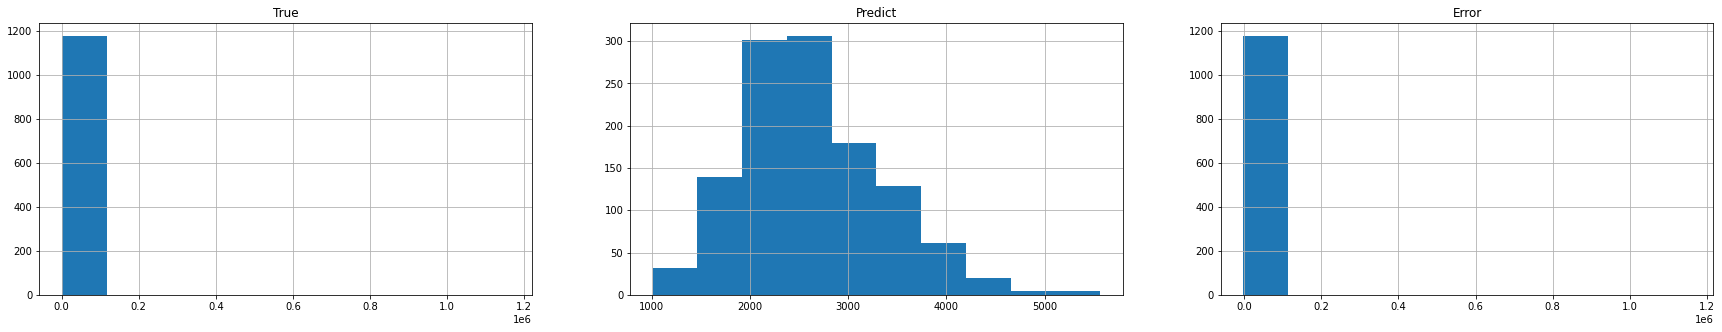

In [32]:
y_pred = Model(lgb.LGBMRegressor()).fit_predict(X, y, prep=np.log1p, posp=np.expm1, clip=True)

In [34]:
error = (y - y_pred)

In [35]:
error

array([  -2039.61887035,   -1382.86244394,   -1272.88164577, ...,
         10318.87763649,   11511.48836164, 1158896.95484374])

In [36]:
maior_erro = abs(error) == abs(error).max()

In [41]:
error[maior_erro]

array([1158896.95484374])

In [37]:
y[maior_erro]

array([1162000])

In [38]:
y_pred[maior_erro]

array([3103.04515626])

In [39]:
X[maior_erro]

,point_lat,point_lon,usable_area,floors,bedrooms,bathrooms,elevator,service_area,kitchen_cabinets,party_hall,intercom,playground,builtin_wardrobe,air_conditioning,balcony,gated_community,distance,publicationType_PREMIUM,publicationType_STANDARD,publicationType_SUPER_PREMIUM,type_unit_APARTMENT,type_unit_CONDOMINIUM,type_unit_HOME,type_unit_KITNET,type_unit_PENTHOUSE,type_unit_RESIDENTIAL_BUILDING,type_unit_TWO_STORY_HOUSE,type_unit_VILLAGE_HOUSE,linha_,linha_Linha 1 do Metrô do Rio de Janeiro,linha_Linha 2 do Metrô do Rio de Janeiro,linha_Linha Belford Roxo da SuperVia,linha_Linha Japeri da SuperVia,linha_Linha Santa Cruz da SuperVia,estacao_,estacao_Estação Afonso Pena,estacao_Estação Campo Grande (Rio de Janeiro),estacao_Estação Estácio,estacao_Estação Mangueira (SuperVia),estacao_Estação Maracanã (Metrô Rio),estacao_Estação Matadouro,estacao_Estação Praça da Bandeira,estacao_Estação Saens Peña,estacao_Estação São Cristóvão (Rio de Janeiro),estacao_Estação São Francisco Xavier (Metrô Rio),estacao_Estação São Francisco Xavier (SuperVia),estacao_Estação Uruguai
1176,-22.919542,-43.226278,108,-1.0,3,3,True,False,False,False,False,False,False,False,False,True,269.572366,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [42]:
df[maior_erro]

,url,title,description,publicationType,media,street,streetNumber,complement,point_lat,point_lon,amenities,usable_area,floors,type_unit,advertiserContact_phones,whatsappNumber,bedrooms,bathrooms,price,condo_fee,total_fee,elevator,service_area,kitchen_cabinets,party_hall,intercom,playground,builtin_wardrobe,air_conditioning,balcony,gated_community,linha,estacao,distance,pred,error
1176,https://www.zapimoveis.com.br/imovel/aluguel-a...,Apartamento para aluguel possui 108 metros qua...,Oportunidade: apartamento no bairro Tijuca com...,PREMIUM,[https://resizedimgs.zapimoveis.com.br/fit-in/...,Rua Almirante Cochrane,78,,-22.919542,-43.226278,"[GATED_COMMUNITY, ELEVATOR]",108,-1.0,APARTMENT,"[21979425556, 21999987873]",21999987873,3,3,2000,1160000,1162000,True,False,False,False,False,False,False,False,False,True,Linha 1 do Metrô do Rio de Janeiro,Estação São Francisco Xavier (Metrô Rio),269.572366,3281.606463,1.158718e+06
